# Notebook 13: Generative Adversarial Networks (GANs)

## Learning Objectives

By the end of this notebook, you will:
1. Understand the GAN framework: generator vs discriminator
2. Implement and train a basic GAN on MNIST
3. Build a Deep Convolutional GAN (DCGAN)
4. Understand training challenges and solutions (WGAN, WGAN-GP)

**Prerequisites**: Notebooks 01-04, 07 (CNNs)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)

Using device: cuda


---
## 1. GAN Theory: A Two-Player Game

GANs consist of two networks playing a minimax game:

- **Generator (G)**: Creates fake samples from random noise
- **Discriminator (D)**: Distinguishes real from fake samples

```
Noise z ~ N(0,1) → [Generator] → Fake image
                                    ↓
Real image ──────────────────→ [Discriminator] → Real/Fake?
```

### The Minimax Objective

$$\min_G \max_D \mathbb{E}_{x \sim p_{data}}[\log D(x)] + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]$$

- **D wants to maximize**: correctly classify real as real, fake as fake
- **G wants to minimize**: make D classify fake as real

In [3]:
# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Scale to [-1, 1]
])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)

---
## 2. Simple GAN (MLP-based)

Let's start with a basic fully-connected GAN:

In [3]:
class Generator(nn.Module):
    """MLP Generator: noise → image"""
    
    def __init__(self, latent_dim=100, img_dim=784):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_dim),
            nn.Tanh()  # Output in [-1, 1]
        )
    
    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    """MLP Discriminator: image → real/fake probability"""
    
    def __init__(self, img_dim=784):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        return self.net(img.view(-1, 784))

In [4]:
def show_samples(generator, n=16, latent_dim=100):
    """Generate and display samples."""
    generator.eval()
    with torch.no_grad():
        z = torch.randn(n, latent_dim).to(device)
        samples = generator(z)
    
    # Denormalize from [-1,1] to [0,1]
    samples = (samples + 1) / 2
    
    grid = make_grid(samples, nrow=int(np.sqrt(n)), padding=2)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.cpu().permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()
    generator.train()

In [5]:
def train_gan(G, D, train_loader, epochs=50, latent_dim=100, lr=2e-4):
    """Train GAN with standard binary cross-entropy loss."""
    
    opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
    criterion = nn.BCELoss()
    
    history = {'d_loss': [], 'g_loss': []}
    
    for epoch in range(epochs):
        d_loss_sum, g_loss_sum = 0, 0
        
        for real_imgs, _ in train_loader:
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            
            # Labels
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            
            # ==================
            # Train Discriminator
            # ==================
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = G(z).detach()  # Don't compute G gradients
            
            d_real = D(real_imgs)
            d_fake = D(fake_imgs)
            
            d_loss = criterion(d_real, real_labels) + criterion(d_fake, fake_labels)
            
            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()
            
            # ===============
            # Train Generator
            # ===============
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = G(z)
            d_fake = D(fake_imgs)
            
            # G wants D to think fakes are real
            g_loss = criterion(d_fake, real_labels)
            
            opt_G.zero_grad()
            g_loss.backward()
            opt_G.step()
            
            d_loss_sum += d_loss.item()
            g_loss_sum += g_loss.item()
        
        n = len(train_loader)
        history['d_loss'].append(d_loss_sum / n)
        history['g_loss'].append(g_loss_sum / n)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss_sum/n:.4f}, G Loss: {g_loss_sum/n:.4f}")
            show_samples(G, n=16, latent_dim=latent_dim)
    
    return history

Epoch 10/50 - D Loss: 0.9770, G Loss: 1.4076


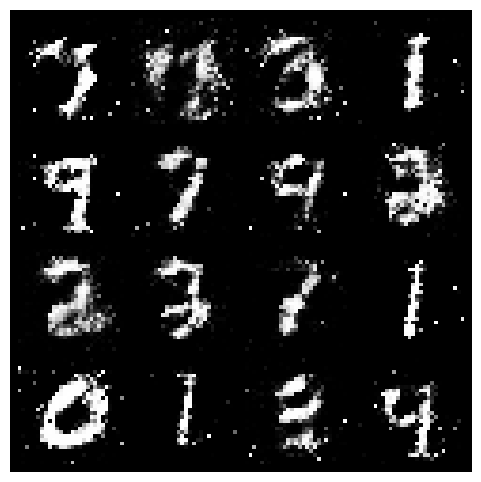

Epoch 20/50 - D Loss: 1.2284, G Loss: 0.9631


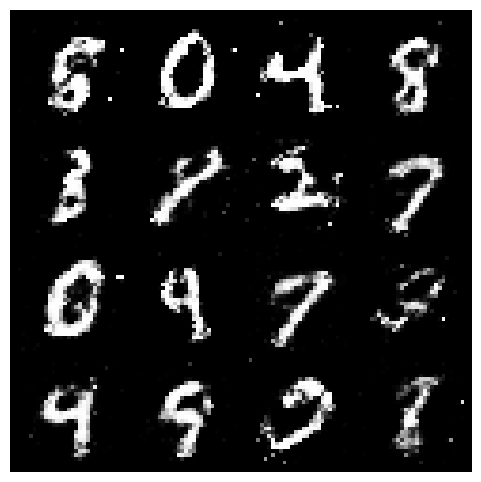

Epoch 30/50 - D Loss: 1.2688, G Loss: 0.9138


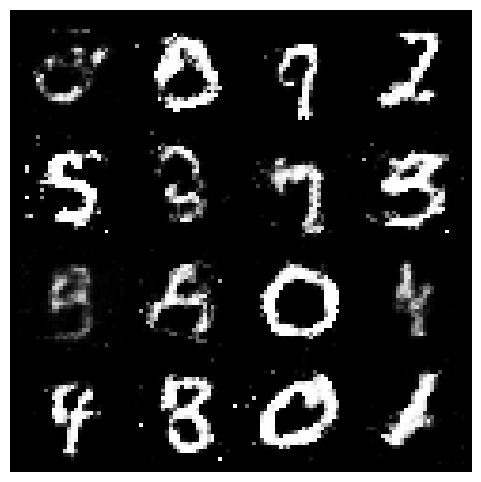

Epoch 40/50 - D Loss: 1.2833, G Loss: 0.8831


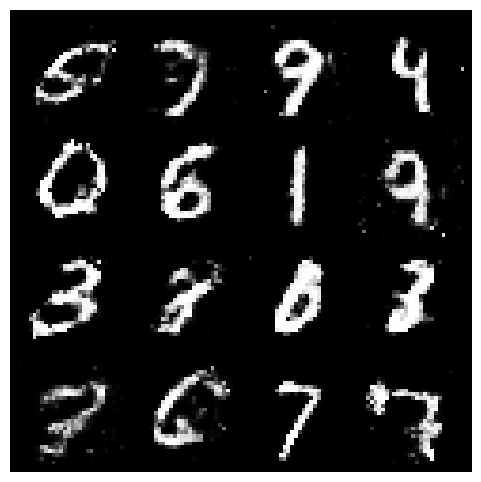

Epoch 50/50 - D Loss: 1.2965, G Loss: 0.8657


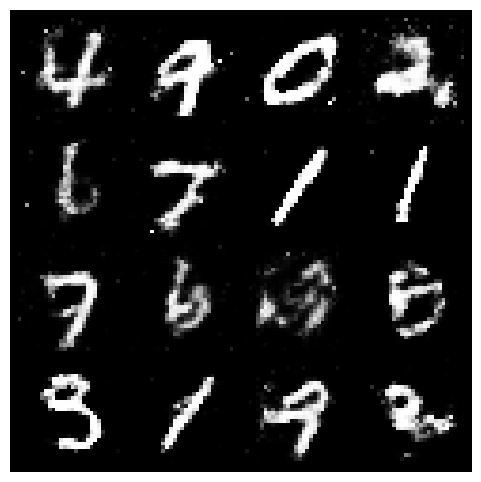

In [6]:
# Train simple GAN
latent_dim = 100
G = Generator(latent_dim).to(device)
D = Discriminator().to(device)

history = train_gan(G, D, train_loader, epochs=50, latent_dim=latent_dim)

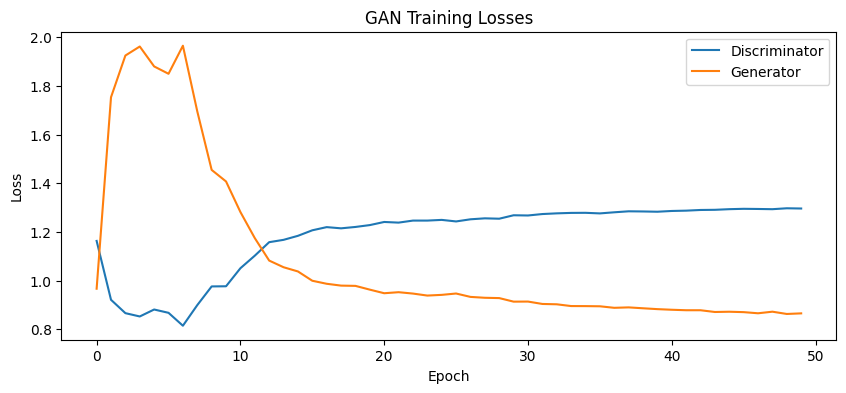

In [7]:
# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(history['d_loss'], label='Discriminator')
plt.plot(history['g_loss'], label='Generator')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Training Losses')
plt.show()

---
## 3. Deep Convolutional GAN (DCGAN)

DCGANs use convolutional layers for better image quality. Key architecture guidelines:
- Use strided convolutions (no pooling)
- BatchNorm in both G and D (except output layers)
- ReLU in G, LeakyReLU in D
- Tanh output in G, no activation in D output

In [8]:
class DCGenerator(nn.Module):
    """DCGAN Generator for 28x28 images."""
    
    def __init__(self, latent_dim=100, channels=1):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Project and reshape: latent_dim -> 256x7x7
        self.fc = nn.Linear(latent_dim, 256 * 7 * 7)
        
        self.conv = nn.Sequential(
            # 256x7x7 -> 128x14x14
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # 128x14x14 -> 1x28x28
            nn.ConvTranspose2d(128, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z):
        x = self.fc(z).view(-1, 256, 7, 7)
        return self.conv(x)


class DCDiscriminator(nn.Module):
    """DCGAN Discriminator for 28x28 images."""
    
    def __init__(self, channels=1):
        super().__init__()
        
        self.conv = nn.Sequential(
            # 1x28x28 -> 64x14x14
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 64x14x14 -> 128x7x7
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        features = self.conv(img)
        return self.fc(features)

In [9]:
def weights_init(m):
    """Initialize weights as recommended for DCGAN."""
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)

# Initialize DCGAN
latent_dim = 100
dc_G = DCGenerator(latent_dim).to(device)
dc_D = DCDiscriminator().to(device)
dc_G.apply(weights_init)
dc_D.apply(weights_init)

print(f"Generator params: {sum(p.numel() for p in dc_G.parameters()):,}")
print(f"Discriminator params: {sum(p.numel() for p in dc_D.parameters()):,}")

Generator params: 1,793,536
Discriminator params: 138,625


Epoch 10/50 - D Loss: 0.4644, G Loss: 2.2530


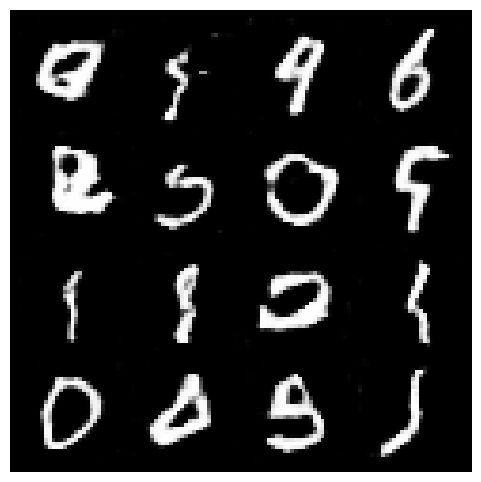

Epoch 20/50 - D Loss: 0.4115, G Loss: 2.7289


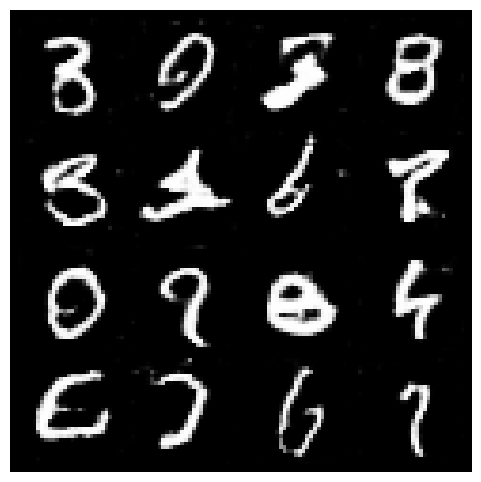

Epoch 30/50 - D Loss: 0.4558, G Loss: 2.9832


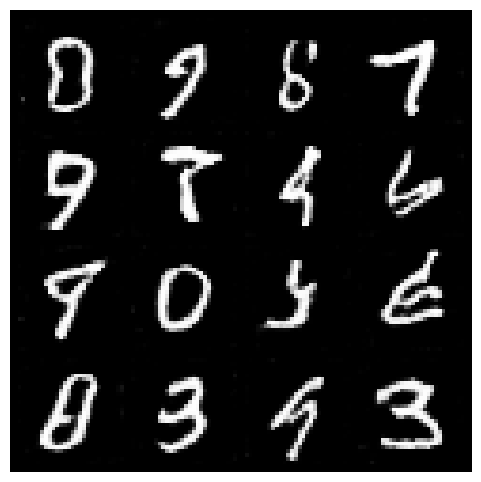

Epoch 40/50 - D Loss: 0.3323, G Loss: 3.2791


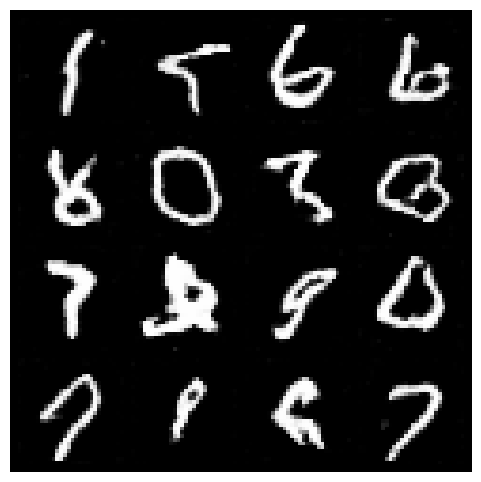

Epoch 50/50 - D Loss: 0.2860, G Loss: 3.4421


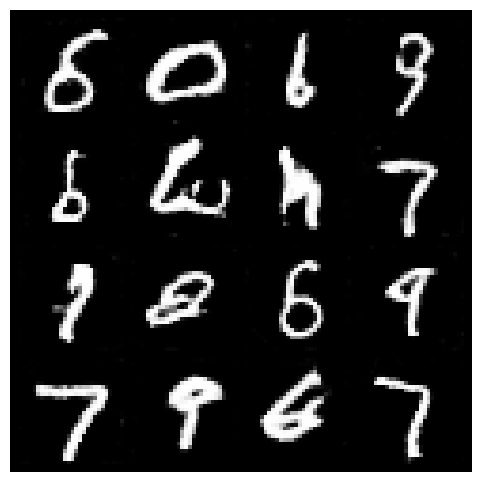

In [10]:
# Train DCGAN
dc_history = train_gan(dc_G, dc_D, train_loader, epochs=50, latent_dim=latent_dim)

DCGAN Generated Samples:


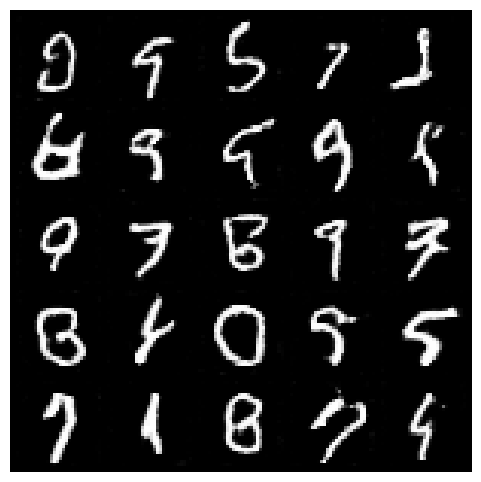

In [11]:
# Final samples from DCGAN
print("DCGAN Generated Samples:")
show_samples(dc_G, n=25, latent_dim=latent_dim)

---
## 4. GAN Training Challenges

GANs are notoriously difficult to train. Common issues:

### Mode Collapse
Generator produces limited variety of samples.

In [12]:
def check_mode_collapse(generator, n_samples=100, latent_dim=100):
    """Check for mode collapse by measuring output diversity."""
    generator.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim).to(device)
        samples = generator(z).view(n_samples, -1)
        
        # Compute pairwise distances
        dists = torch.cdist(samples, samples)
        # Exclude diagonal (self-distances)
        mask = ~torch.eye(n_samples, dtype=bool, device=device)
        mean_dist = dists[mask].mean().item()
        min_dist = dists[mask].min().item()
    
    print(f"Mean pairwise distance: {mean_dist:.4f}")
    print(f"Min pairwise distance: {min_dist:.4f}")
    print("(Low values suggest mode collapse)")
    generator.train()

check_mode_collapse(dc_G, latent_dim=latent_dim)

Mean pairwise distance: 20.4813
Min pairwise distance: 9.3330
(Low values suggest mode collapse)


### Vanishing Gradients
When D is too strong, G gets no learning signal.

### Training Instability
Losses oscillate wildly; one network dominates.

---
## 5. Wasserstein GAN (WGAN)

WGAN addresses training instability by using the Wasserstein distance instead of JS divergence.

### Key Changes:
1. **No sigmoid in D** (now called "critic")
2. **Wasserstein loss**: $L_D = D(fake) - D(real)$, $L_G = -D(fake)$
3. **Weight clipping** to enforce Lipschitz constraint

In [13]:
class WCritic(nn.Module):
    """WGAN Critic (no sigmoid)."""
    
    def __init__(self, channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),
            
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1)  # No sigmoid!
        )
    
    def forward(self, img):
        return self.net(img)

In [14]:
def train_wgan(G, C, train_loader, epochs=50, latent_dim=100, 
               lr=5e-5, n_critic=5, clip_value=0.01):
    """Train WGAN with weight clipping."""
    
    opt_G = torch.optim.RMSprop(G.parameters(), lr=lr)
    opt_C = torch.optim.RMSprop(C.parameters(), lr=lr)
    
    history = {'c_loss': [], 'g_loss': []}
    
    for epoch in range(epochs):
        c_loss_sum, g_loss_sum = 0, 0
        g_steps = 0
        
        for i, (real_imgs, _) in enumerate(train_loader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            
            # ==============
            # Train Critic (more frequently)
            # ==============
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = G(z).detach()
            
            # Wasserstein loss: maximize C(real) - C(fake)
            c_loss = C(fake_imgs).mean() - C(real_imgs).mean()
            
            opt_C.zero_grad()
            c_loss.backward()
            opt_C.step()
            
            # Weight clipping
            for p in C.parameters():
                p.data.clamp_(-clip_value, clip_value)
            
            c_loss_sum += c_loss.item()
            
            # ===============
            # Train Generator (less frequently)
            # ===============
            if (i + 1) % n_critic == 0:
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_imgs = G(z)
                
                # G wants to maximize C(fake)
                g_loss = -C(fake_imgs).mean()
                
                opt_G.zero_grad()
                g_loss.backward()
                opt_G.step()
                
                g_loss_sum += g_loss.item()
                g_steps += 1
        
        history['c_loss'].append(c_loss_sum / len(train_loader))
        history['g_loss'].append(g_loss_sum / max(g_steps, 1))
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - C Loss: {history['c_loss'][-1]:.4f}, "
                  f"G Loss: {history['g_loss'][-1]:.4f}")
            show_samples(G, n=16, latent_dim=latent_dim)
    
    return history

Epoch 10/50 - C Loss: -0.1987, G Loss: -4.7826


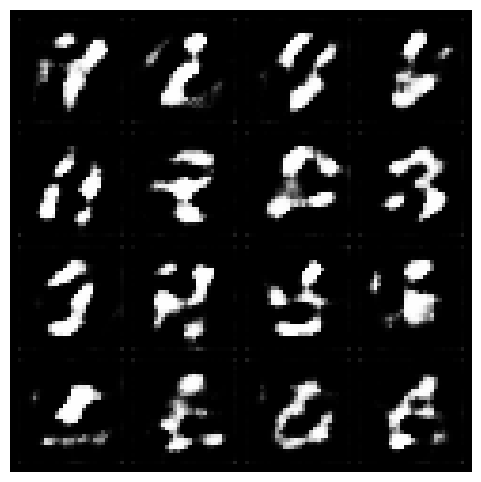

Epoch 20/50 - C Loss: -0.0367, G Loss: -1.4988


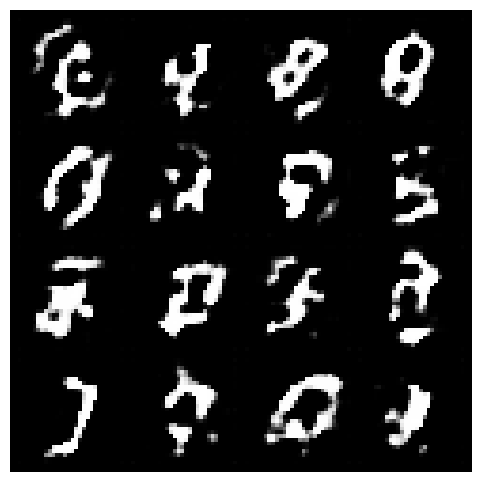

Epoch 30/50 - C Loss: -0.0511, G Loss: -0.7914


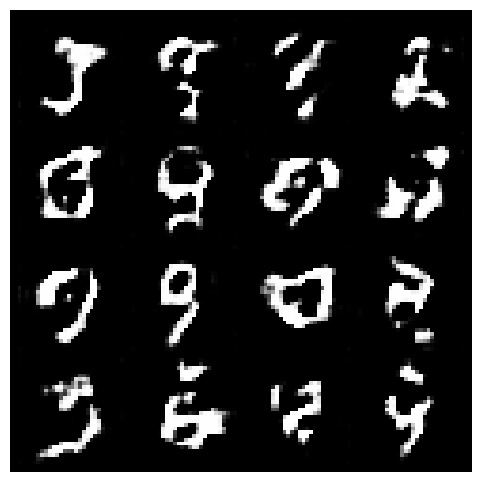

Epoch 40/50 - C Loss: -0.0355, G Loss: -0.8011


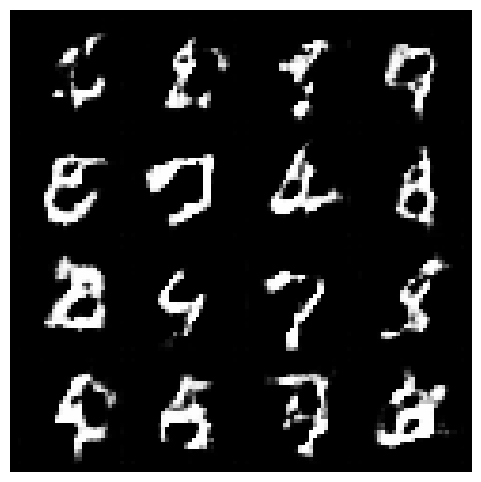

Epoch 50/50 - C Loss: -0.0244, G Loss: -0.9314


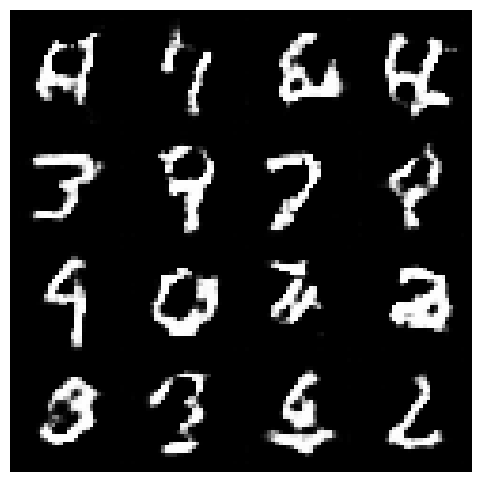

In [15]:
# Train WGAN
wgan_G = DCGenerator(latent_dim).to(device)
wgan_C = WCritic().to(device)
wgan_G.apply(weights_init)
wgan_C.apply(weights_init)

wgan_history = train_wgan(wgan_G, wgan_C, train_loader, epochs=50, latent_dim=latent_dim)

---
## 6. WGAN with Gradient Penalty (WGAN-GP)

Weight clipping can cause issues. WGAN-GP uses a **gradient penalty** instead to enforce the Lipschitz constraint:

$$L = L_{WGAN} + \lambda \mathbb{E}_{\hat{x}}[(\|\nabla_{\hat{x}} D(\hat{x})\|_2 - 1)^2]$$

Where $\hat{x}$ is interpolated between real and fake samples.

In [16]:
def gradient_penalty(critic, real, fake):
    """Compute gradient penalty for WGAN-GP."""
    batch_size = real.size(0)
    
    # Random interpolation coefficient
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)
    
    # Interpolate between real and fake
    interpolated = alpha * real + (1 - alpha) * fake
    interpolated.requires_grad_(True)
    
    # Critic score on interpolated
    critic_interp = critic(interpolated)
    
    # Compute gradients
    gradients = torch.autograd.grad(
        outputs=critic_interp,
        inputs=interpolated,
        grad_outputs=torch.ones_like(critic_interp),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # Gradient norm penalty
    gradients = gradients.view(batch_size, -1)
    grad_norm = gradients.norm(2, dim=1)
    penalty = ((grad_norm - 1) ** 2).mean()
    
    return penalty

In [17]:
class WCriticGP(nn.Module):
    """WGAN-GP Critic (no BatchNorm - interferes with GP)."""
    
    def __init__(self, channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),  # InstanceNorm instead of BatchNorm
            nn.LeakyReLU(0.2),
            
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1)
        )
    
    def forward(self, img):
        return self.net(img)

In [18]:
def train_wgan_gp(G, C, train_loader, epochs=50, latent_dim=100,
                  lr=1e-4, n_critic=5, lambda_gp=10):
    """Train WGAN with gradient penalty."""
    
    opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.0, 0.9))
    opt_C = torch.optim.Adam(C.parameters(), lr=lr, betas=(0.0, 0.9))
    
    history = {'c_loss': [], 'g_loss': [], 'gp': []}
    
    for epoch in range(epochs):
        c_loss_sum, g_loss_sum, gp_sum = 0, 0, 0
        g_steps = 0
        
        for i, (real_imgs, _) in enumerate(train_loader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            
            # ==============
            # Train Critic
            # ==============
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = G(z).detach()
            
            c_real = C(real_imgs).mean()
            c_fake = C(fake_imgs).mean()
            gp = gradient_penalty(C, real_imgs, fake_imgs)
            
            c_loss = c_fake - c_real + lambda_gp * gp
            
            opt_C.zero_grad()
            c_loss.backward()
            opt_C.step()
            
            c_loss_sum += c_loss.item()
            gp_sum += gp.item()
            
            # ===============
            # Train Generator
            # ===============
            if (i + 1) % n_critic == 0:
                z = torch.randn(batch_size, latent_dim).to(device)
                fake_imgs = G(z)
                
                g_loss = -C(fake_imgs).mean()
                
                opt_G.zero_grad()
                g_loss.backward()
                opt_G.step()
                
                g_loss_sum += g_loss.item()
                g_steps += 1
        
        n = len(train_loader)
        history['c_loss'].append(c_loss_sum / n)
        history['g_loss'].append(g_loss_sum / max(g_steps, 1))
        history['gp'].append(gp_sum / n)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - C: {history['c_loss'][-1]:.4f}, "
                  f"G: {history['g_loss'][-1]:.4f}, GP: {history['gp'][-1]:.4f}")
            show_samples(G, n=16, latent_dim=latent_dim)
    
    return history

Epoch 10/50 - C: -3.9802, G: 11.9479, GP: 0.0561


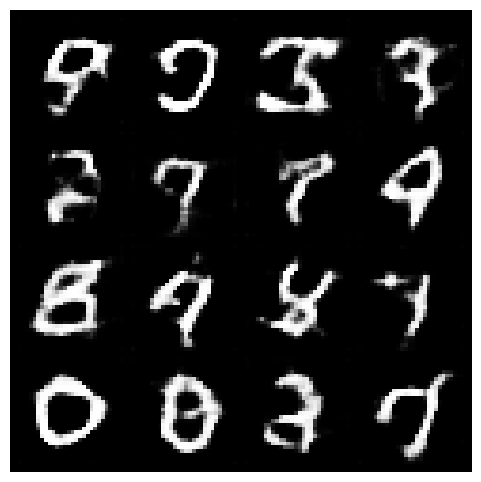

Epoch 20/50 - C: -3.1232, G: 1.1188, GP: 0.0410


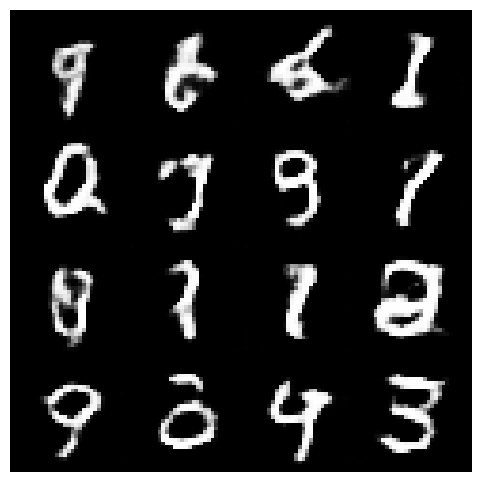

Epoch 30/50 - C: -2.9367, G: 1.1018, GP: 0.0400


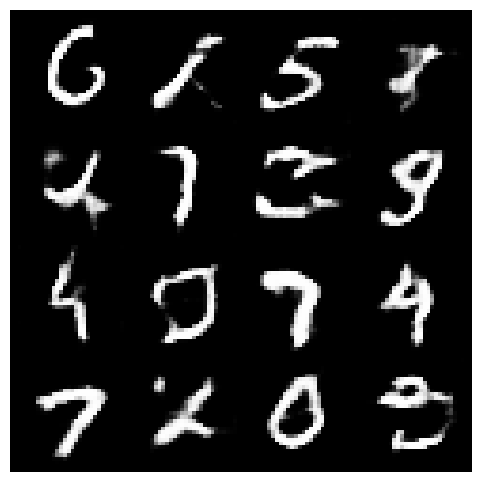

Epoch 40/50 - C: -2.8397, G: 1.6225, GP: 0.0392


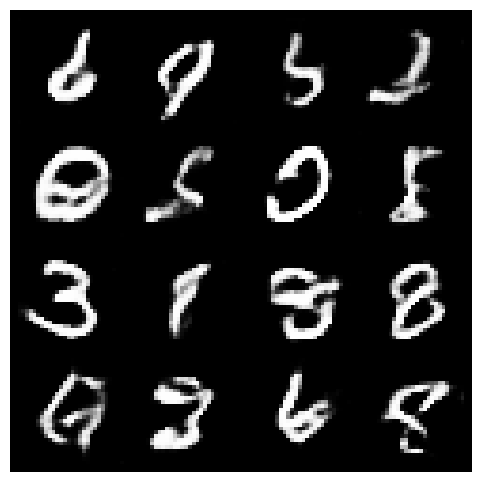

Epoch 50/50 - C: -2.7774, G: 3.0086, GP: 0.0385


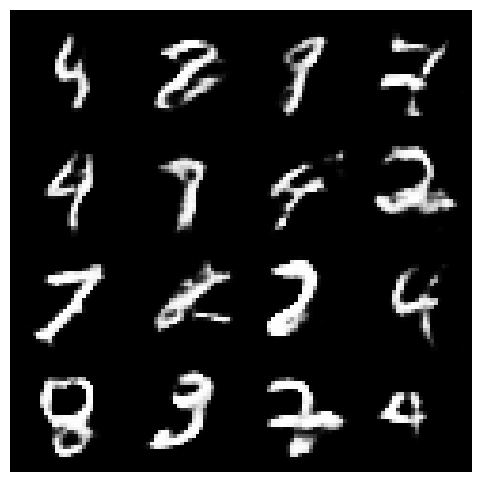

In [19]:
# Train WGAN-GP
wgangp_G = DCGenerator(latent_dim).to(device)
wgangp_C = WCriticGP().to(device)
wgangp_G.apply(weights_init)

wgangp_history = train_wgan_gp(wgangp_G, wgangp_C, train_loader, epochs=50, latent_dim=latent_dim)

Final samples comparison:


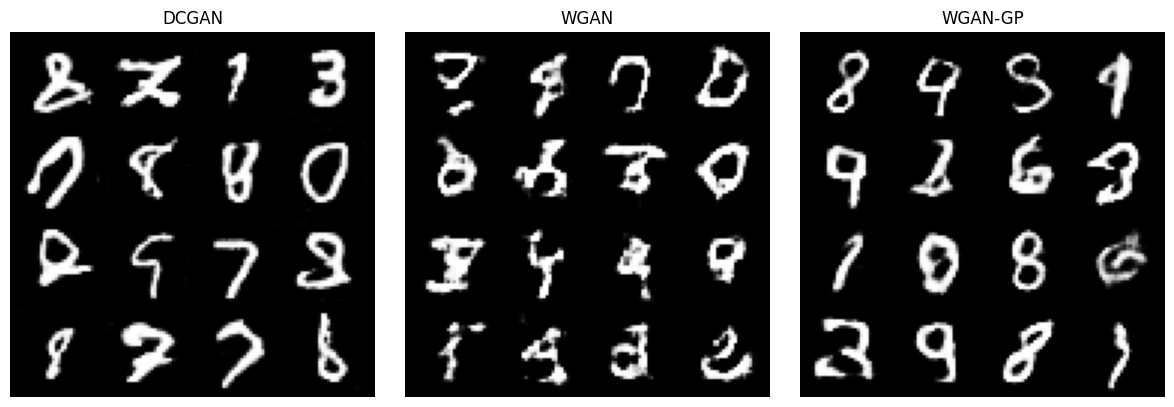

In [28]:
# Compare all methods
print("Final samples comparison:")
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, (name, gen) in zip(axes, [('DCGAN', dc_G), ('WGAN', wgan_G), ('WGAN-GP', wgangp_G)]):
    gen.eval()
    with torch.no_grad():
        z = torch.randn(16, latent_dim).to(device)
        samples = (gen(z) + 1) / 2
    grid = make_grid(samples, nrow=4, padding=2)
    ax.imshow(grid.cpu().permute(1, 2, 0).squeeze(), cmap='gray')
    ax.set_title(name)
    ax.axis('off')

plt.tight_layout()
plt.show()

---
## 7. Latent Space Exploration

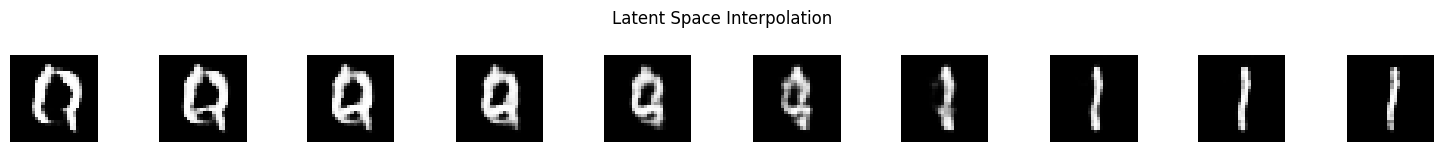

In [29]:
def interpolate_latent(generator, z1, z2, steps=10):
    """Interpolate between two latent vectors."""
    generator.eval()
    alphas = torch.linspace(0, 1, steps).to(device)
    
    with torch.no_grad():
        interpolations = []
        for alpha in alphas:
            z = (1 - alpha) * z1 + alpha * z2
            img = generator(z.unsqueeze(0))
            interpolations.append(img)
    
    return torch.cat(interpolations)

# Interpolate
z1 = torch.randn(latent_dim).to(device)
z2 = torch.randn(latent_dim).to(device)

interp = interpolate_latent(wgangp_G, z1, z2, steps=10)
interp = (interp + 1) / 2

fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i, ax in enumerate(axes):
    ax.imshow(interp[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle('Latent Space Interpolation')
plt.tight_layout()
plt.show()

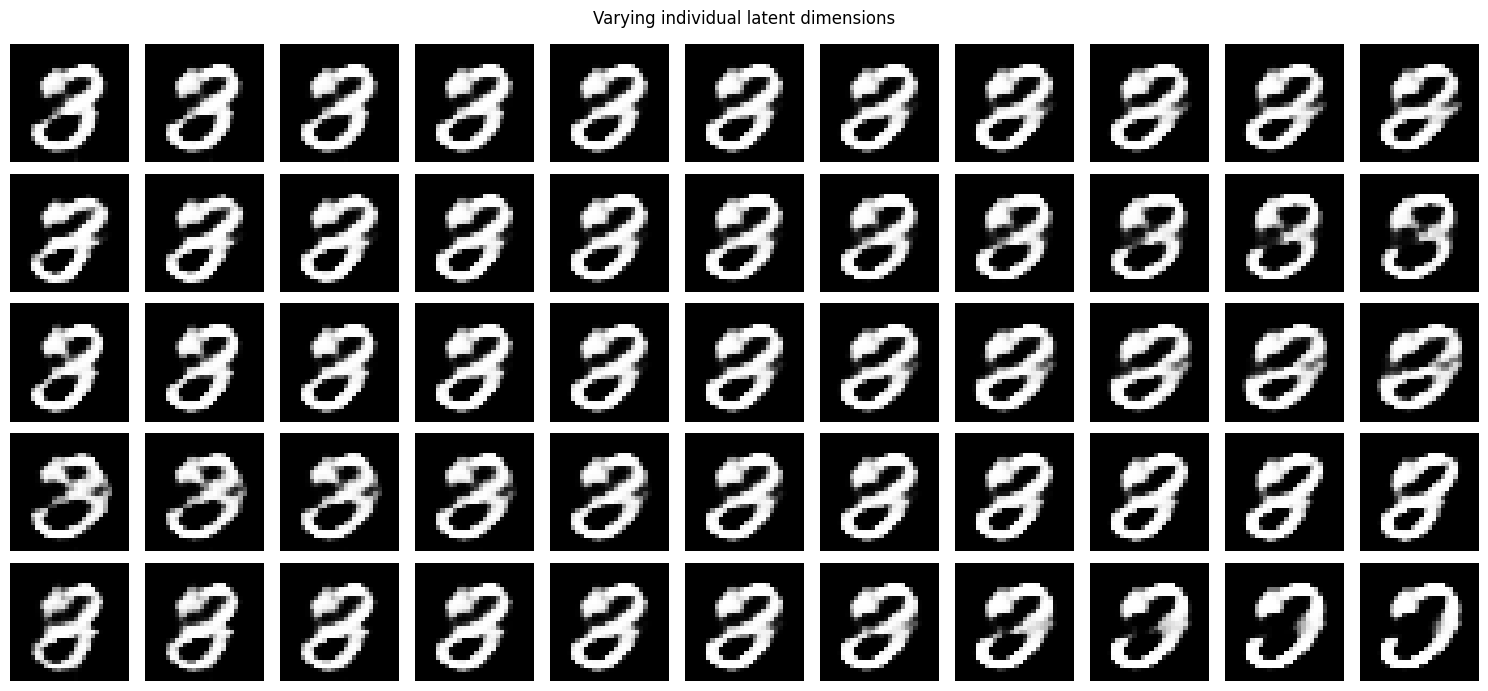

In [30]:
def latent_arithmetic(generator, latent_dim):
    """Demonstrate latent space arithmetic."""
    generator.eval()
    
    # Generate several samples and find interesting directions
    with torch.no_grad():
        z_base = torch.randn(1, latent_dim).to(device)
        
        # Vary different dimensions
        fig, axes = plt.subplots(5, 11, figsize=(15, 7))
        
        for row, dim in enumerate([0, 10, 25, 50, 75]):
            for col, val in enumerate(np.linspace(-3, 3, 11)):
                z = z_base.clone()
                z[0, dim] = val
                img = generator(z)
                img = (img + 1) / 2
                axes[row, col].imshow(img[0].cpu().squeeze(), cmap='gray')
                axes[row, col].axis('off')
            axes[row, 0].set_ylabel(f'dim {dim}', fontsize=10)
        
        plt.suptitle('Varying individual latent dimensions')
        plt.tight_layout()
        plt.show()

latent_arithmetic(wgangp_G, latent_dim)

---
## 8. Summary

### GAN Variants Comparison

| Variant | Loss | Constraint | Pros | Cons |
|---------|------|------------|------|------|
| **GAN** | BCE | None | Simple | Unstable, mode collapse |
| **WGAN** | Wasserstein | Weight clipping | More stable | Slow, capacity issues |
| **WGAN-GP** | Wasserstein + GP | Gradient penalty | Best stability | Slower per step |

### Key Concepts

| Concept | Description |
|---------|-------------|
| **Generator** | Maps noise z → fake images |
| **Discriminator/Critic** | Classifies real vs fake |
| **Mode Collapse** | G produces limited variety |
| **Wasserstein Distance** | Earth mover's distance, more stable gradients |
| **Gradient Penalty** | Enforces Lipschitz constraint on critic |

### Training Tips

1. Use LeakyReLU in discriminator
2. Use BatchNorm (except WGAN-GP critic)
3. Adam with β₁=0.5 for standard GAN
4. Train D more than G (n_critic=5 for WGAN)
5. Monitor for mode collapse

---
## Exercises

### Exercise 1: Conditional GAN (cGAN)
Modify the DCGAN to condition on class labels, enabling generation of specific digits.

### Exercise 2: Fashion-MNIST GAN
Train a WGAN-GP on Fashion-MNIST. Compare generated clothing items.

### Exercise 3: Training Stability Analysis
Compare training curves of GAN, WGAN, and WGAN-GP over 100 epochs. Which is most stable?

---
## Solutions

In [6]:
# Solution 1: Conditional GAN
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, 50)
        
        self.fc = nn.Linear(latent_dim + 50, 256 * 7 * 7)
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        label_emb = self.label_emb(labels)
        x = torch.cat([z, label_emb], dim=1)
        x = self.fc(x).view(-1, 256, 7, 7)
        return self.conv(x)


class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, 28 * 28)
        
        self.conv = nn.Sequential(
            nn.Conv2d(2, 64, 4, 2, 1),  # 2 channels: image + label
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img, labels):
        label_map = self.label_emb(labels).view(-1, 1, 28, 28)
        x = torch.cat([img, label_map], dim=1)
        return self.conv(x)


# Train cGAN
cG = ConditionalGenerator(latent_dim).to(device)
cD = ConditionalDiscriminator().to(device)
cG.apply(weights_init)
cD.apply(weights_init)

opt_G = torch.optim.Adam(cG.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(cD.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()

for epoch in range(30):
    for real_imgs, labels in train_loader:
        batch_size = real_imgs.size(0)
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # Train D
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = cG(z, labels).detach()
        
        d_loss = criterion(cD(real_imgs, labels), real_labels) + \
                 criterion(cD(fake_imgs, labels), fake_labels)
        opt_D.zero_grad()
        d_loss.backward()
        opt_D.step()
        
        # Train G
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = cG(z, labels)
        g_loss = criterion(cD(fake_imgs, labels), real_labels)
        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/30")

# Generate specific digits
cG.eval()
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
with torch.no_grad():
    for digit in range(10):
        z = torch.randn(2, latent_dim).to(device)
        labels = torch.tensor([digit, digit]).to(device)
        imgs = (cG(z, labels) + 1) / 2
        for row in range(2):
            axes[row, digit].imshow(imgs[row].cpu().squeeze(), cmap='gray')
            axes[row, digit].axis('off')
        axes[0, digit].set_title(str(digit))
plt.suptitle('Conditional GAN: Generating Specific Digits')
plt.tight_layout()
plt.show()

NameError: name 'weights_init' is not defined

In [6]:
# Solution 2: Fashion-MNIST GAN
fashion_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
fashion_data = datasets.FashionMNIST('../data', train=True, download=True, transform=fashion_transform)
fashion_loader = DataLoader(fashion_data, batch_size=128, shuffle=True, drop_last=True)

fashion_G = DCGenerator(latent_dim).to(device)
fashion_C = WCriticGP().to(device)
fashion_G.apply(weights_init)

print("Training WGAN-GP on Fashion-MNIST...")
fashion_history = train_wgan_gp(fashion_G, fashion_C, fashion_loader, epochs=30, latent_dim=latent_dim)

print("\nFashion-MNIST Generated Samples:")
show_samples(fashion_G, n=25, latent_dim=latent_dim)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.69MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.15MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 30.2MB/s]


NameError: name 'DCGenerator' is not defined

In [ ]:
# Solution 3: Training Stability Analysis
# Compare loss variance as stability metric

def compute_stability(history, key):
    """Compute rolling variance of loss."""
    losses = np.array(history[key])
    # Rolling variance with window=10
    window = 10
    if len(losses) < window:
        return np.var(losses)
    variances = [np.var(losses[max(0,i-window):i+1]) for i in range(len(losses))]
    return np.mean(variances[window:])

print("Training Stability Analysis (lower = more stable):")
print(f"DCGAN G-loss variance: {compute_stability(dc_history, 'g_loss'):.4f}")
print(f"WGAN G-loss variance: {compute_stability(wgan_history, 'g_loss'):.4f}")
print(f"WGAN-GP G-loss variance: {compute_stability(wgangp_history, 'g_loss'):.4f}")

# Plot losses
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].plot(dc_history['g_loss'], label='G')
axes[0].plot(dc_history['d_loss'], label='D')
axes[0].set_title('DCGAN')
axes[0].legend()

axes[1].plot(wgan_history['g_loss'], label='G')
axes[1].plot(wgan_history['c_loss'], label='C')
axes[1].set_title('WGAN')
axes[1].legend()

axes[2].plot(wgangp_history['g_loss'], label='G')
axes[2].plot(wgangp_history['c_loss'], label='C')
axes[2].set_title('WGAN-GP')
axes[2].legend()

for ax in axes:
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- DCGAN: Oscillating losses, potential instability")
print("- WGAN: Smoother but can plateau")
print("- WGAN-GP: Most stable training dynamics")